# Potato disease detection

data credits => https://www.kaggle.com/datasets/arjuntejaswi/plant-village?resource=download

## Install all Libs

In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os

## Set all contants

In [4]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 30

## Import data into tensorflow dataset object

We will use image_dataset_from_directory api to load all images in tensorflow dataset: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillageData",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


## Class Names

In [6]:
class_names = dataset.class_names
print(class_names)

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [7]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


## Visualize some of the images from our dataset

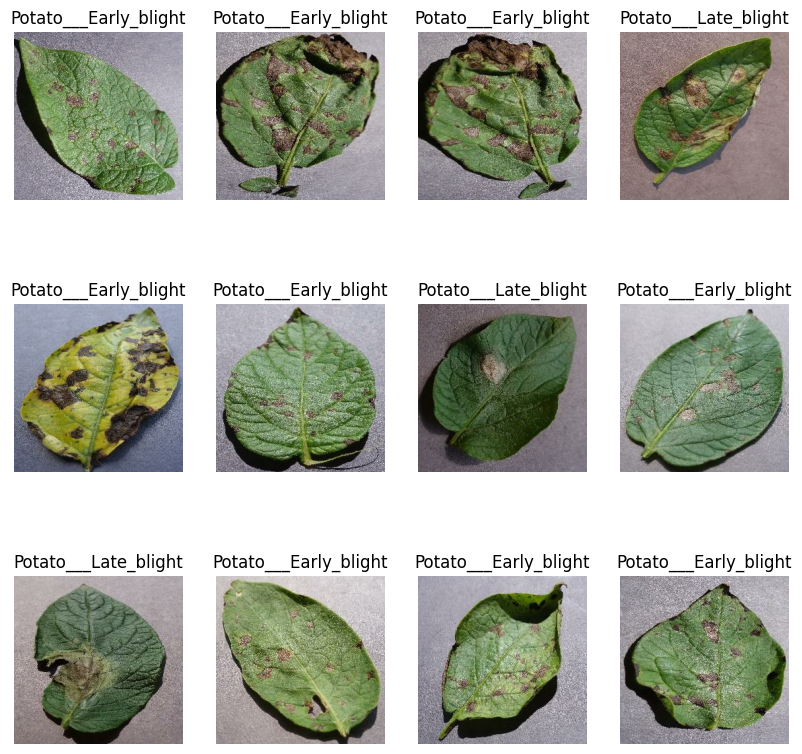

In [8]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

## Data Distribution Check

In [9]:
print("\n=== Data Distribution Check ===")
def count_all_samples(dataset):
    class_counts = [0, 0, 0]
    for _, labels in dataset:
        for label in labels.numpy():
            class_counts[label] += 1
    return class_counts

real_counts = count_all_samples(dataset)
total_samples = sum(real_counts)
print(f"Total samples: {total_samples}")
for i, count in enumerate(real_counts):
    percentage = (count / total_samples) * 100
    print(f"{class_names[i]}: {count} samples ({percentage:.1f}%)")


=== Data Distribution Check ===
Total samples: 2152
Potato___Early_blight: 1000 samples (46.5%)
Potato___Late_blight: 1000 samples (46.5%)
Potato___healthy: 152 samples (7.1%)


## Function to Split Dataset
Dataset should be bifurcated into 3 subsets, namely:

1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

train = 80%, validation = 10%, test = 10%

In [10]:
len(dataset)

68

In [11]:
train_size = 0.8
len(dataset)*0.8

54.400000000000006

In [12]:
train_ds = dataset.take(54)
len(train_ds)

54

In [13]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [14]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [15]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [16]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [17]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [18]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

print(f"legth of train dataset => ", len(train_ds))
print(f"legth of validation dataset => ", len(val_ds))
print(f"legth of test dataset => ", len(test_ds))

legth of train dataset =>  54
legth of validation dataset =>  6
legth of test dataset =>  8


## Resize the image to 256, 256 pixels. we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256)

In [19]:
def preprocess_data(x, y):
    x = tf.image.resize(x, [IMAGE_SIZE, IMAGE_SIZE])
    x = tf.cast(x, tf.float32) / 255.0
    return x, y

## Data Augmentation
This Data Augmentation is intended to increase the diversity of training data and prevent overfitting by creating new image models from the original data.


> Original image → Flip left-right → Flip up-down → Both

In [ ]:
def augment_data_enhanced(x, y):
    # Basic augmentation for all classes
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_flip_up_down(x)
    
    # Enhanced augmentation
    x = tf.image.random_brightness(x, max_delta=0.15)
    x = tf.image.random_contrast(x, lower=0.85, upper=1.15)
    
    # Random rotation
    random_rotations = tf.random.uniform([], 0, 4, dtype=tf.int32)
    x = tf.image.rot90(x, k=random_rotations)
    
    # Additional augmentations
    x = tf.image.random_saturation(x, lower=0.9, upper=1.1)
    
    return x, y

## Cache, Shuffle, and Prefetch the Dataset


In [21]:
train_ds = train_ds.map(preprocess_data).map(augment_data_enhanced).cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess_data).cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(preprocess_data).cache().prefetch(tf.data.AUTOTUNE)

This code provides **optimization** for TensorFlow Dataset to accelerate model training speed. Each command works as follows:

## `.cache()`
- **Stores data in memory** after the first load and processing
- In subsequent epochs, no need to reload data from disk, making it much faster
- Suitable for datasets that are not too large and require multiple epochs

## `.shuffle(1000)`
- **Randomizes data order** with a buffer size of 1000 items
- Prevents the model from memorizing data order (overfitting to data order)
- Helps make learning more stable and accurate
- Note: For test sets, shuffling is typically unnecessary

## `.prefetch(buffer_size=tf.data.AUTOTUNE)`
- **Preloads data** while the GPU is processing the current batch
- `AUTOTUNE` allows TensorFlow to automatically adjust buffer size for optimal performance
- Reduces waiting time between GPU and data loading

## Processing Pipeline
```
Raw Data → cache → shuffle → prefetch → Send to Model
```

## Results
- **Faster**: GPU doesn't wait for data, data cached in memory
- **Better Learning**: Shuffling prevents overfitting
- **Efficient Resource Usage**: CPU and GPU work simultaneously

## Recommendation
For test sets, remove `.shuffle()` since randomizing test data is unnecessary:
```python
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
```

## Class Weights Calculation from real dataset

In [22]:
print("\n=== Class Weights Calculation ===")
n_classes = len(class_names)
class_weights = {}
for i, count in enumerate(real_counts):
    class_weights[i] = total_samples / (n_classes * count)
    print(f"Class {i} ({class_names[i]}): weight = {class_weights[i]:.3f}")

input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)


=== Class Weights Calculation ===
Class 0 (Potato___Early_blight): weight = 0.717
Class 1 (Potato___Late_blight): weight = 0.717
Class 2 (Potato___healthy): weight = 4.719


## Model Architecture
We use a CNN coupled with a Softmax activation in the output layer.

In [23]:
model = models.Sequential([
    # Conv Block 1
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    # Conv Block 2
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    # Conv Block 3
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    
    # Conv Block 4
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    
    layers.GlobalAveragePooling2D(),
    
    # Dense layers with heavy regularization
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(n_classes, activation='softmax'),
])


c:\ML Engineer\deep learning\Potato Disease Detection\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           38

 Total params: 259,651 (1014.26 KB)

 Trainable params: 258,691 (1010.51 KB)

 Non-trainable params: 960 (3.75 KB)

## Callbacks function for controlling training

In [25]:
callbacks = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
]

## Compiling the Model
We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [26]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

## Training Model

In [ ]:
print("\n=== Training Model ===")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)


=== Training Model ===
Epoch 1/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.7237 - loss: 0.7201 - val_accuracy: 0.4531 - val_loss: 3.3490 - learning_rate: 0.0010
Epoch 2/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.8825 - loss: 0.3470 - val_accuracy: 0.4531 - val_loss: 4.9941 - learning_rate: 0.0010
Epoch 3/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.9030 - loss: 0.2391 - val_accuracy: 0.4531 - val_loss: 6.9555 - learning_rate: 0.0010
Epoch 4/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.9217 - loss: 0.1662 - val_accuracy: 0.4531 - val_loss: 7.6001 - learning_rate: 0.0010
Epoch 5/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.9136 - loss: 0.2021 - val_accuracy: 0.4531 - val_loss: 5.1669 - learning_rate: 0.0010
Epoch 6/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9431 - loss: 0.1718
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
54/54 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.9430 - loss: 

In [28]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 54}

In [29]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])

In [30]:
type(history.history['loss'])

list

In [31]:
len(history.history['loss']) # 50 EPOCH

30

In [32]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.5602702498435974,
 0.32935503125190735,
 0.23906955122947693,
 0.1763128936290741,
 0.1664551943540573]

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [34]:
scores = model.evaluate(test_ds)
print(f"Test accuracy: {scores[1]:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 275ms/step - accuracy: 0.9774 - loss: 0.0660
Test accuracy: 0.9688


# Show Performance

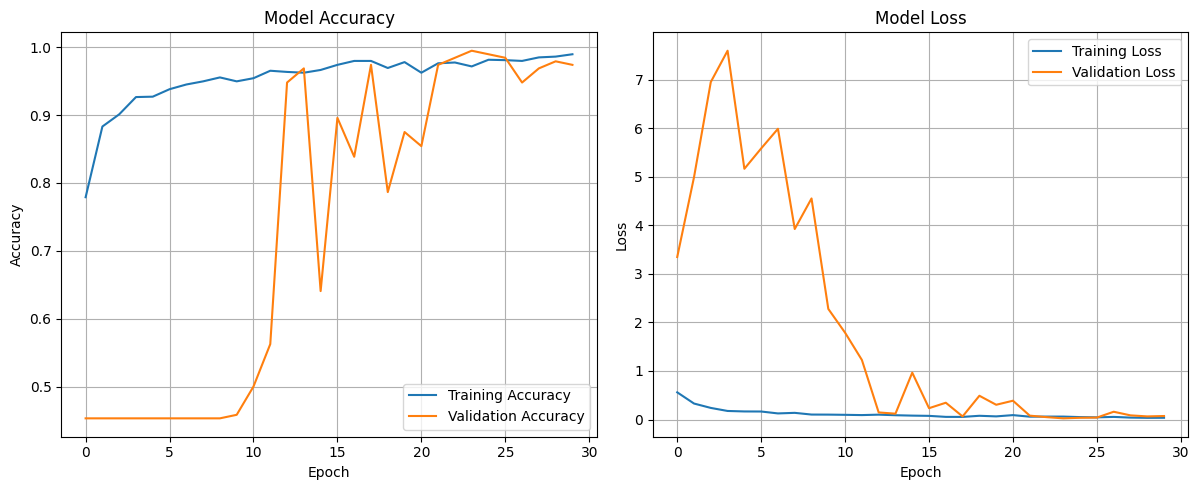

In [35]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## Run prediction on a sample image

In [36]:
# Predict on test set
y_pred = []
y_true = []

print("Generating predictions for analysis...")
for images, labels in test_ds:
    predictions = model.predict(images, verbose=0)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(labels.numpy())

Generating predictions for analysis...


## Confusion Matrix

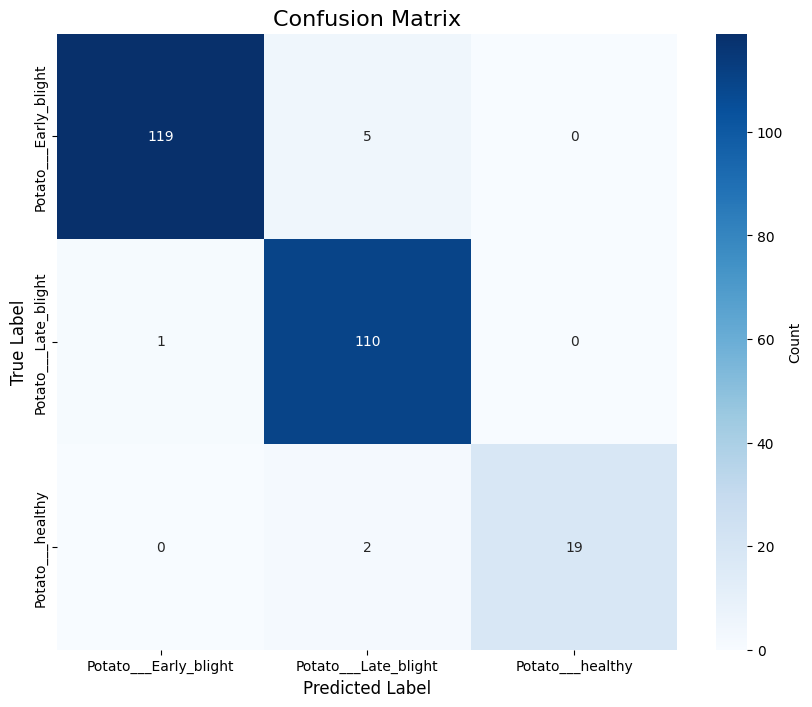

In [37]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

## Classification Report


In [38]:
print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=class_names))


=== Classification Report ===
                       precision    recall  f1-score   support

Potato___Early_blight       0.99      0.96      0.98       124
 Potato___Late_blight       0.94      0.99      0.96       111
     Potato___healthy       1.00      0.90      0.95        21

             accuracy                           0.97       256
            macro avg       0.98      0.95      0.96       256
         weighted avg       0.97      0.97      0.97       256



## Per-class accuracy


In [39]:
print("\n=== Per-Class Accuracy ===")
for i, class_name in enumerate(class_names):
    if cm[i].sum() > 0:
        class_acc = cm[i, i] / cm[i].sum()
        print(f"{class_name}: {class_acc:.4f} ({cm[i, i]}/{cm[i].sum()})")


=== Per-Class Accuracy ===
Potato___Early_blight: 0.9597 (119/124)
Potato___Late_blight: 0.9910 (110/111)
Potato___healthy: 0.9048 (19/21)


## Saving the Model
We append the model to the list of models as a new version

In [ ]:
models_dir = "../models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

# Find the next version number
existing_files = [f for f in os.listdir(models_dir) if f.startswith("potato_model_v") and f.endswith(".keras")]
if existing_files:
    # Extract version numbers
    versions = []
    for filename in existing_files:
        try:
            version_str = filename.replace("potato_model_v", "").replace(".keras", "")
            versions.append(int(version_str))
        except ValueError:
            continue
    model_version = max(versions) + 1 if versions else 1
else:
    model_version = 1

model_filename = f"potato_model_v{model_version}.keras"
model_path = os.path.join(models_dir, model_filename)

model.save(model_path)
print(f"\n[Success!] Model saved to: {model_path}")

print("\n=== Training Complete! ===")
print(f"Final Results:")
print(f"- Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"- Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"- Test Accuracy: {scores[1]:.4f}")
print(f"- Model Version: v{model_version}")
print(f"- Saved as: {model_filename}")


[Success!] Model saved to: models\potato_model_v2.keras

=== Training Complete! ===
Final Results:
- Training Accuracy: 0.9896
- Validation Accuracy: 0.9740
- Test Accuracy: 0.9688
- Model Version: v2
- Saved as: potato_model_v2.keras
